# Vehicle Detection & Tracking Project

In [1]:
import matplotlib.image as mpimg
import numpy as np
import cv2
from skimage.feature import hog
import glob
import matplotlib.pyplot as plt
import time
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.externals import joblib
from scipy.ndimage.measurements import label
from collections import deque

## Fetching Data from Dataset

In [2]:
car_image_names = glob.glob('vehicles/*/*.png')
noncar_image_names = glob.glob('non-vehicles/*/*.png')

car_images = []
noncar_images = []

for image_name in car_image_names:
    car_images.append(cv2.cvtColor(cv2.imread(image_name),cv2.COLOR_BGR2RGB))

for image_name in noncar_image_names:    
    noncar_images.append(cv2.cvtColor(cv2.imread(image_name),cv2.COLOR_BGR2RGB))

print("Data Loaded Successfully!")    

Data Loaded Successfully!


Your function returned a count of 8792  cars and 8968  non-cars
of size:  (64, 64, 3)  and data type: uint8


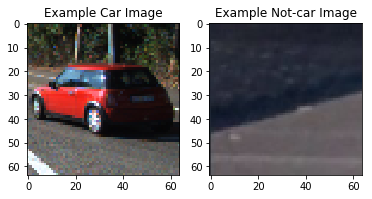

In [3]:
# Define a function to return some characteristics of the dataset 
def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    test_image = car_list[0]
    # Define a key "image_shape" and store the test image shape 3-tuple
    data_dict["image_shape"] = test_image.shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = test_image.dtype
    # Return data_dict
    return data_dict
    
data_info = data_look(car_images, noncar_images)

print('Your function returned a count of', 
      data_info["n_cars"], ' cars and', 
      data_info["n_notcars"], ' non-cars')
print('of size: ',data_info["image_shape"], ' and data type:', 
      data_info["data_type"])

# random car / not-car indices and plot example images   
car_ind = np.random.randint(0, len(car_images))
notcar_ind = np.random.randint(0, len(noncar_images))
    
# Read in car / not-car images
car_image = car_images[car_ind]
notcar_image = noncar_images[notcar_ind]


# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(car_image)
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(notcar_image)
plt.title('Example Not-car Image')
plt.show()

## Features Extraction

In [5]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  block_norm= 'L2-Hys',
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       block_norm= 'L2-Hys',
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Normalization
def normalize(x):
    return (x-min(x))/(max(x)-min(x))

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(image, color_space='YCrCb', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel="ALL",
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    
    # Create a list to append feature vectors to
    features = []
    feature_image = None
    spatial_features = None
    hist_features = None
    hog_features = None
    
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(image)      

    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        features.append(normalize(spatial_features))
        
    if hist_feat == True:
        # Apply color_hist()
        hist_features = color_hist(feature_image, nbins=hist_bins)
        features.append(normalize(hist_features))
        
    if hog_feat == True:
    # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        features.append(normalize(hog_features))
    # Return list of feature vectors
    return np.concatenate(features)

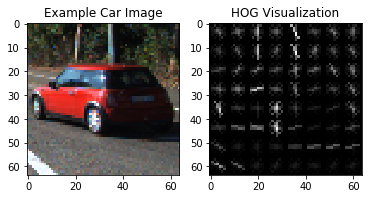

C:\Users\shubhadeep.majumdar\AppData\Local\Continuum\Miniconda3\envs\carnd-term1\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


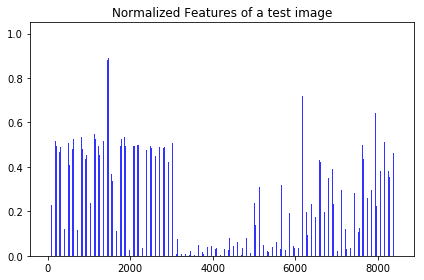

In [5]:
features, hog_image = get_hog_features(cv2.cvtColor(car_image,cv2.COLOR_RGB2GRAY), orient= 9, 
                        pix_per_cell= 8, cell_per_block= 2, 
                        vis=True, feature_vec=False)


# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(car_image)
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')
plt.show()

fig2 = plt.figure()
image_features = extract_features(car_image)
index = np.arange(len(image_features))
bar_width = 0.35
opacity = 0.8
 
rects = plt.bar(index, image_features, bar_width,
                 alpha=opacity,
                 color='b') 
plt.title('Normalized Features of a test image')
plt.legend()
plt.tight_layout()
plt.show()

## Training of Classifier

In [6]:
def train_clf(images,labels,c_space='YCrCb',s_size=(32, 32),
                h_bins=32,ornt=9,pix_cell=8,cell_block=2,
                h_channel='ALL',s_feat=True,hi_feat=True,ho_feat=True):
    
    features = []
    for image in images:
        features.append(extract_features(image,color_space=c_space,spatial_size=s_size,
                                         hist_bins=h_bins,orient=ornt,pix_per_cell=pix_cell, cell_per_block=cell_block, 
                                         hog_channel=h_channel,spatial_feat=s_feat,hist_feat=hi_feat,hog_feat=ho_feat))
    
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(
    features, labels, test_size=0.2, random_state=rand_state)
    
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X_train)
    # Apply the scaler to X
    X_train = X_scaler.transform(X_train)
    X_test = X_scaler.transform(X_test)
    
    clf = LinearSVC()
    clf = clf.fit(X_train,y_train)
    score = clf.score(X_test,y_test)
    return clf,score,X_scaler

In [7]:
images = np.concatenate((car_images,noncar_images))
car_labels = np.ones(len(car_images))
noncar_labels = np.zeros(len(noncar_images))
labels = np.concatenate((car_labels,noncar_labels))

In [8]:
t=time.time()
clf, score, X_scaler = train_clf(images,labels)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train classifier...')
# Check the score of the classifier
print('Test Accuracy of classifier = ', round(score, 4))

194.84 Seconds to train classifier...
Test Accuracy of classifier =  0.9882


### Save Model

In [9]:
print('Saving Model:')
joblib.dump(clf, './clf.pkl')
joblib.dump(X_scaler, './scaler.pkl')
print('Done!')

Saving Model:
Done!


### Load Model

In [2]:
clf = joblib.load('./clf.pkl')
X_scaler = joblib.load('./scaler.pkl')
print("Classifier loaded successfully")

Classifier loaded successfully


## Vehicle Tracking

In [20]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='YCrCb', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel='ALL', spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = extract_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

# Function to track Car with different window sizes
def track_car(img):
    windows_big = slide_window(img, x_start_stop=[700, None], 
                           y_start_stop=[400, 700], xy_window=(100, 100), 
                           xy_overlap=(0.75, 0.75))
    windows_small = slide_window(img, x_start_stop=[700, None], 
                           y_start_stop=[400, 500], xy_window=(60, 60), 
                           xy_overlap=(0.8, 0.8))
    windows = windows_big+windows_small
    tracked_pos = search_windows(img, windows, clf, X_scaler)
    return tracked_pos

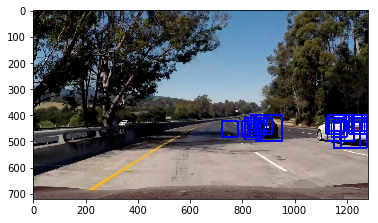

In [44]:
test_images = glob.glob('test_images/test*.jpg')
images = []
for image in test_images:
    images.append(cv2.cvtColor(cv2.imread(image),cv2.COLOR_BGR2RGB))

img = images[4]
tracked_pos = track_car(img)
plt.imshow(draw_boxes(img, tracked_pos, color=(0, 0, 255), thick=6))

In [45]:
heatmaps = deque(maxlen=10)
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

def label_car(img, tracked_pos):
    global heatmaps
    
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    heat = add_heat(heat, tracked_pos)
    if (len(tracked_pos)!=0):
        heatmaps.append(heat)
        avg_heat = sum(heatmaps)/len(heatmaps)
        heat = avg_heat
    else:
        heatmaps = deque(maxlen=10)
    
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,2)
    
    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)
    
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img, heatmap

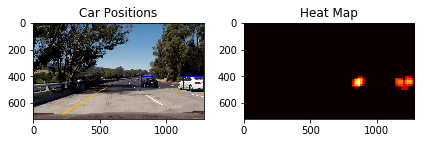

In [46]:
draw_img, heatmap = label_car(img, tracked_pos)

fig = plt.figure()
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()

## Pipeline

In [47]:
def pipeline(image):
    tracked_pos = track_car(image)
    draw_img, heatmap = label_car(image, tracked_pos)
    return draw_img

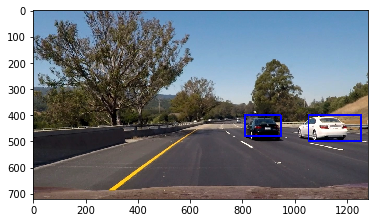

In [54]:
test_image = cv2.cvtColor(cv2.imread('test_images/test6.jpg'),cv2.COLOR_BGR2RGB)
output_image = pipeline(test_image)
plt.imshow(output_image)

In [56]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
heatmaps = deque(maxlen=10)
output_video = 'project_video_ouput.mp4'

## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip = VideoFileClip("project_video.mp4")
white_clip = clip.fl_image(pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output_video, audio=False)

[MoviePy] >>>> Building video project_video_ouput.mp4
[MoviePy] Writing video project_video_ouput.mp4


100%|███████████████████████████████████████████████████████████████████████████▉| 1260/1261 [1:14:29<00:03,  3.53s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_ouput.mp4 

Wall time: 1h 14min 31s
